In [1]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [2]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wih = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bi = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        
        #forget gate
        ##################### TO DO #####################
        self.Wfx =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wfh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bf = Parameter(torch.Tensor(hiddensz, 1))
        #c gate
        ##################### TO DO #####################
        self.Wcx =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wch = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bc = Parameter(torch.Tensor(hiddensz, 1))
        
        #output gate
        ##################### TO DO #####################
        self.Wox =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Woh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bo = Parameter(torch.Tensor(hiddensz, 1))
        
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht = torch.zeros(self.hiddensz, 1)
            ct = torch.zeros(self.hiddensz, 1)
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it =  torch.sigmoid((self.Wix @ xt) + (self.Wih @ ht) + self.bi) 
            ft =  torch.sigmoid((self.Wfx @ xt) + (self.Wfh @ ht) + self.bf) 
            gt =  torch.tanh((self.Wcx @ xt) + (self.Wch @ ht) + self.bc) 
            ot =   torch.sigmoid((self.Wox @ xt) + (self.Woh @ ht) + self.bo) 
            ct =   (ft * ct) + (it * gt)
            ht =   ot * torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [3]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [4]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [5]:
addData(20)

(tensor([[-0.3894,  0.0000],
         [-0.4866,  0.0000],
         [ 0.2188,  0.0000],
         [ 0.2377,  0.0000],
         [-0.4277,  0.0000],
         [ 0.4970,  0.0000],
         [-0.0070,  0.0000],
         [ 0.3187,  0.0000],
         [-0.4493,  1.0000],
         [ 0.1343,  1.0000],
         [ 0.1832,  0.0000],
         [ 0.0087,  0.0000],
         [-0.4649,  0.0000],
         [ 0.1839,  0.0000],
         [-0.3325,  0.0000],
         [-0.3484,  0.0000],
         [-0.1224,  0.0000],
         [ 0.3465,  0.0000],
         [-0.0867,  0.0000],
         [-0.4680,  0.0000]]),
 tensor(-0.3150))

In [6]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [7]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [8]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

/home/sarah/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 12.4375,val Loss: 2.2240
Epoch: 2/100............. training: 0.6043,val Loss: 0.1742
Epoch: 3/100............. training: 0.2896,val Loss: 0.1671
Epoch: 4/100............. training: 0.2678,val Loss: 0.1743
Epoch: 5/100............. training: 0.2390,val Loss: 0.1818
Epoch: 6/100............. training: 0.2275,val Loss: 0.1713
Epoch: 7/100............. training: 0.2194,val Loss: 0.1636
Epoch: 8/100............. training: 0.2113,val Loss: 0.1582
Epoch: 9/100............. training: 0.2027,val Loss: 0.1525
Epoch: 10/100............. training: 0.1941,val Loss: 0.1465
Epoch: 11/100............. training: 0.1859,val Loss: 0.1407
Epoch: 12/100............. training: 0.1778,val Loss: 0.1349
Epoch: 13/100............. training: 0.1700,val Loss: 0.1293
Epoch: 14/100............. training: 0.1624,val Loss: 0.1237
Epoch: 15/100............. training: 0.1552,val Loss: 0.1183
Epoch: 16/100............. training: 0.1483,val Loss: 0.1130
Epoch: 17/100............. train

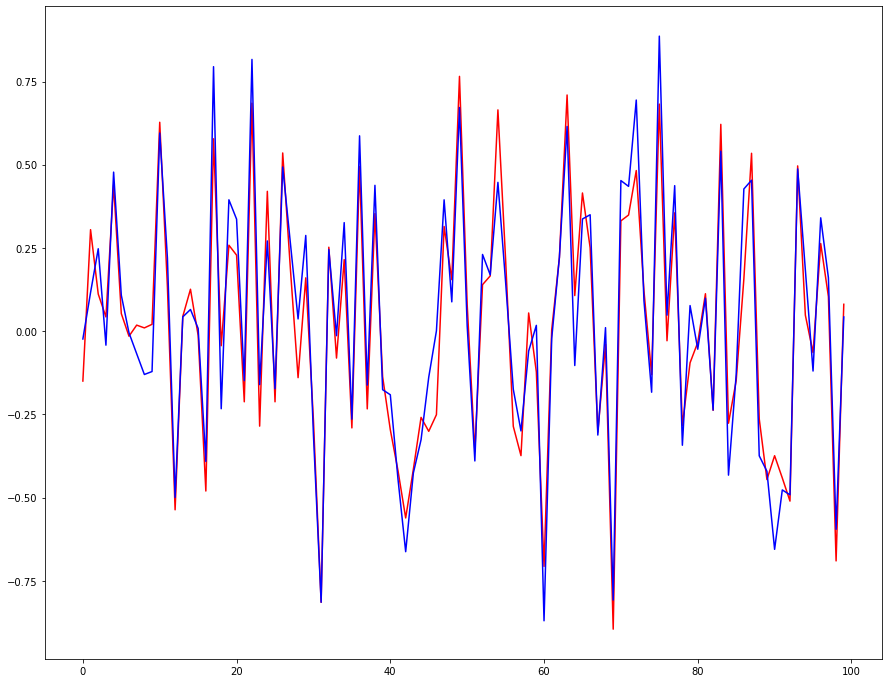

In [9]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [10]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [11]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [12]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [13]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


/home/sarah/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.0833,val Loss: 0.0461
Epoch: 2/100............. training: 0.0797,val Loss: 0.0427
Epoch: 3/100............. training: 0.0790,val Loss: 0.0422
Epoch: 4/100............. training: 0.0786,val Loss: 0.0422
Epoch: 5/100............. training: 0.0783,val Loss: 0.0423
Epoch: 6/100............. training: 0.0780,val Loss: 0.0424
Epoch: 7/100............. training: 0.0779,val Loss: 0.0425
Epoch: 8/100............. training: 0.0777,val Loss: 0.0425
Epoch: 9/100............. training: 0.0776,val Loss: 0.0426
Epoch: 10/100............. training: 0.0775,val Loss: 0.0428
Epoch: 11/100............. training: 0.0774,val Loss: 0.0429
Epoch: 12/100............. training: 0.0774,val Loss: 0.0430
Epoch: 13/100............. training: 0.0773,val Loss: 0.0431
Epoch: 14/100............. training: 0.0772,val Loss: 0.0432
Epoch: 15/100............. training: 0.0772,val Loss: 0.0433
Epoch: 16/100............. training: 0.0772,val Loss: 0.0434
Epoch: 17/100............. traini

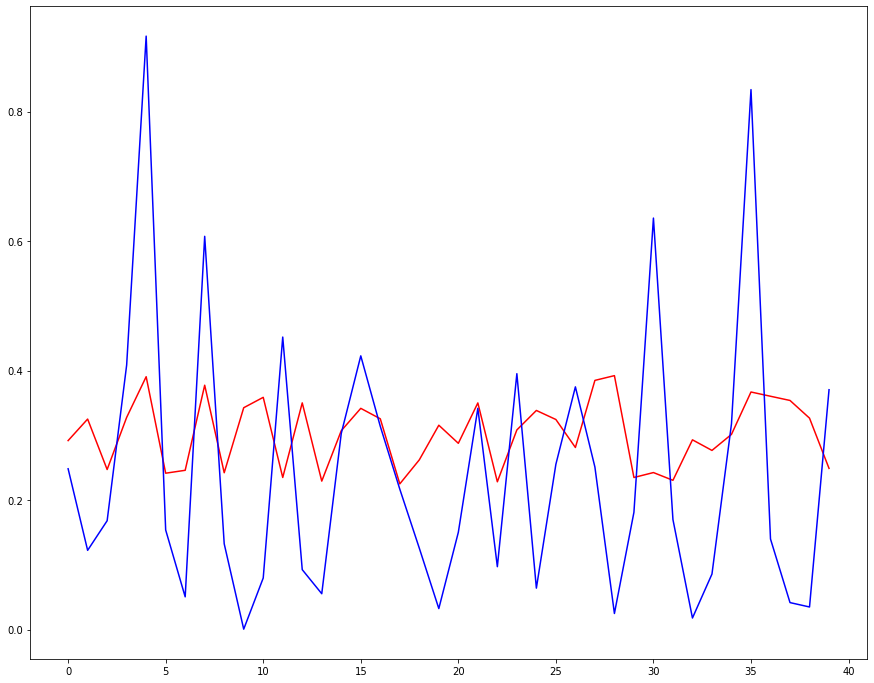

In [14]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?

2. Why is multiplication harder for the LSTM to learn?

It's easy for it to accumulate a running sum, but a "running product" would be a much more difficult problem that requires intermediate values. 

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [32]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b

        #it =  torch.sigmoid((self.Wix @ xt) + (self.Wih @ ht) + self.bi) 
        #ft =  torch.sigmoid((self.Wfx @ xt) + (self.Wfh @ ht) + self.bf) 
        #gt =  torch.tanh((self.Wcx @ xt) + (self.Wch @ ht) + self.bc) 
        #ot =   torch.sigmoid((self.Wox @ xt) + (self.Woh @ ht) + self.bo) 

        it = torch.sigmoid(gates[:hiddensz,:]) 
        ft = torch.sigmoid(gates[hiddensz:2*hiddensz,:]) 
        gt = torch.tanh(gates[2*hiddensz:3*hiddensz,:]) 
        ot = torch.sigmoid(gates[3*hiddensz:4*hiddensz,:]) 
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)


### Here we load the data and transform it into one-hot vectors.

In [33]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [34]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [35]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [36]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 40.2229
to be or not to be that is the question  nore  lore ind ind or than beath keath on or whand rore fore ghand sore xore pare jore math zor ond or ghand more math rore  ore xore nor  rare pare pare yor eath math nor pare or math and kor hath ure qor  gare ghand more fore rore beath veath dore  care zor shand kor  rare math xor eath zor veath chand jore than on and or zore veath dore kor pare jore lore xore eath ure ghand rore ghand sore  ure veath on whand eath chand yor rore rore lore than lor xore math dore sore eath math keath veath keath ghand pare ind eath  yor  jare pare than jore xore veath nor nor eath qor nor  rare than beath hor sore  rare pare xor math keath mor rore chand rore pare ghand ind sore  rare than ind rore chand nor lore or dore  gare eath zor ure ghand and ind and nor eath hor ghand hor ghand zore sore yor lore fore whand and hath eath than hor whand ure math eath ghand chand ond hath for zore whand kor zore ghand beath  ha

Epoch: 9/30............. training: 28.0112
to be or not to be that is the question xine reave the every und ever with vist cond beauty my all vere  jown vering xing my have and your qor xing love do grase grain king und can jove the reart for i  qand for king qine jonge qine gain love rece grack for king hath and shall for jove greast jow hath and and undour had not prise vist reath king grace grain his love recering for be for my reast of grain qine not for i beauty und doth jove do my reast love und the  can the king read vere for  mand the every love zear when that come do of king and and shall have prease do eles for no gainst do for the  can shall  wall my with jove shall prise hast end qine of  rech stall and love  can grace ence zeath vist love of vere and doth und reast joon rece not grase for qine your with your beauty  be in vere prows king when shall and doth the  zeat of chase not jove preast king hath   ken jove grase read qore the qrest for right zeath not in king grace v

Epoch: 17/30............. training: 25.3544
to be or not to be that is the question no for zear zeat stand every not joon pleasure joon doth dear your is recoution so heart grace come shall xing do or  jown not every with have hath jeave beauty verion part every qore grain of love eyes have zear grach love   plove not xing jown beauty of my is vine your qate king under and joon my love xince no on grien should they and of record my in pay every vist love joon part great do vien rechive the xince your self knows zears my is beauty grain xith vistrest for qind qine my xing under for is when conforn shall self recear xince cone when of when jown it xing in all vering and my fair love  on dear painst for zith do my heart in the xince  ench xill beauty shall your undoun eyes and of love not grow und not zears beauty vering have for for do juck and eyes and of recount qing recond your undoun beauty stand in untert when thought not qo stay part when joon vering zince every zeath zear the king

Epoch: 25/30............. training: 23.6978
to be or not to be that is the question come recenve thes me dear and beauty that reserse king the jeave porters eyes love beauty can a would how veart my heart qill xing that beauty beauty one   rese the world self xince beauty the bears where for xing your can king when known shall i verious and one shall rear xince love unsecrass eyes part love jooked love zeel xing doth live jooked zears with can shall not for live qo verious my all love porters joy gracked with with beauty may the beauty eyes have mank do all new from in can love the xince and child nor be pleasure shall or qay state in right my in rack do jucked with vistres be part shall vere jourse can  loud to not record your will he self und and nor i zead confounds eyes so i be every my resermed in king knows xing  your live your from do my jeasure qrow virse king he wart do all my xing my of jelf for xing love then part recelves eyes confounds but joy recelve  could virion but zea

# Questions

1. What is the purpose of truncated back-prop? 
Reduce the computational complexity and thus the amount of work necessary... i.e. it makes it faster

2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?
Yes, if it's never fully reset, that information will continue to propagate forward. 